<a href="https://colab.research.google.com/github/Sepren/Deep-Learning/blob/main/5_laba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания.**

После того, как заявленные значения совпадут и будут получены работающие модели выполните следующие задания:

1. **Базовая часть (3 балла):** исследуйте влияние параметров `gamma, lr_rate, epsilon` на обучение моделей. Постройте графики.
2. **Опциональная часть (+2 балла):** Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

Зададим гиперпараметры модели

In [1]:
epsilon = 0.1 # Параметр эпсилон при использовании эпсилон жадной стратегии
gamma = 0.8 # Коэффциент дисконтирования гамма
random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)
lr_rate = 0.9 #Коэффициент скорости обучения альфа

Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [2]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd /content/gym_0_18_0
!pip install -e. -q

/content/gym_0_18_0
  Preparing metadata (setup.py) ... done


In [3]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFHFF
FHFFHF
FFFHHF
HFFHHF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [4]:
def choose_action(state):
    action = 0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, env.action_space.n) # Случайное действие
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(state, state2, reward, action, done):
    if not done:
        max_future_q = np.max(Q[state2, :])
    else:
        max_future_q = 0

    current_q = Q[state, action]
    target_q = reward + gamma * max_future_q
    Q[state, action] = current_q + lr_rate * (target_q - current_q)

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [5]:
from tqdm import tqdm
# Initialization
np.random.seed(random_seed)
total_games = 10000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
wins = 0  # Счетчик общего количества побед
consecutive_wins = 0  # Счетчик последовательных побед
first_five_wins_game = None  # Номер игры с первыми пятью победами подряд

# Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    t = 0
    while t < max_steps:
        t += 1
        action = choose_action(state)
        state2, reward, done, info = env.step(action)
        if t == max_steps:
            done = True
        learn(state, state2, reward, action, done)
        state = state2
        if done:
            # Проверяем, является ли завершение победой
            if reward == 1:
                wins += 1
                consecutive_wins += 1
                # Если достигнуто 5 побед подряд и это первый раз
                if consecutive_wins >= 5 and first_five_wins_game is None:
                    first_five_wins_game = game + 1  # +1, так как game начинается с 0
            else:
                consecutive_wins = 0  # Сбрасываем при проигрыше
            break

# Вывод результатов
print("Количество побед в серии из 10 000 игр: ", wins)
print("Пять побед подряд впервые было одержано в игре ", first_five_wins_game)

100%|██████████| 10000/10000 [00:05<00:00, 1812.32it/s]

Количество побед в серии из 10 000 игр:  7914
Пять побед подряд впервые было одержано в игре  885


Вывод ответов при заданных параметрах

In [6]:
# Вывод результатов
print("Количество побед в серии из 10 000 игр: ", wins)
print("Пять побед подряд впервые было одержано в игре ", first_five_wins_game)

Количество побед в серии из 10 000 игр:  7914
Пять побед подряд впервые было одержано в игре  885


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [7]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


Отобразим маршрут

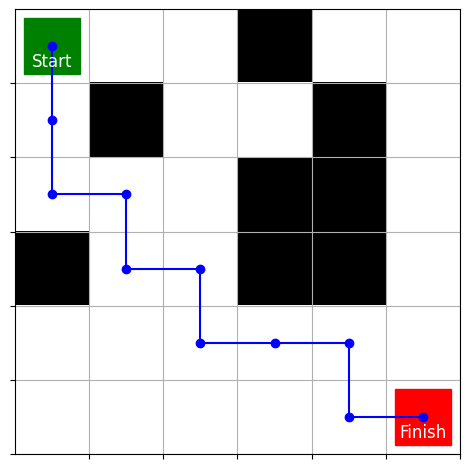

In [8]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

# Задача 3

Используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.



In [9]:
def learn(state, state2, reward, action, action2, done):
    if not done:
        # Используем Q-значение для следующего состояния и действия
        next_q = Q[state2, action2]
    else:
        # Если эпизод завершен, будущая награда равна 0
        next_q = 0

    # Текущее Q-значение
    current_q = Q[state, action]

    # Вычисляем целевое Q-значение по формуле SARSA
    target_q = reward + gamma * next_q

    # Обновляем Q-значение
    Q[state, action] = current_q + lr_rate * (target_q - current_q)

In [10]:
from tqdm import tqdm
# Initialization
np.random.seed(random_seed)
total_games = 40000
max_steps = 100
Q = np.zeros((env.observation_space.n, env.action_space.n))
wins = 0  # Счетчик общего количества побед
consecutive_wins = 0  # Счетчик последовательных побед
first_five_wins_game = None  # Номер игры с первыми пятью победами подряд

# Main cycle
for game in tqdm(range(total_games)):
    state = env.reset()
    action = choose_action(state)  # Выбираем начальное действие
    t = 0
    while t < max_steps:
        t += 1
        state2, reward, done, info = env.step(action)
        action2 = choose_action(state2)  # Выбираем следующее действие
        if t == max_steps:
            done = True
        learn(state, state2, reward, action, action2, done)
        state = state2
        action = action2  # Обновляем текущее действие
        if done:
            if reward == 1:
                wins += 1
                consecutive_wins += 1
                if consecutive_wins >= 5 and first_five_wins_game is None:
                    first_five_wins_game = game + 1
            else:
                consecutive_wins = 0
            break



100%|██████████| 40000/40000 [00:27<00:00, 1458.72it/s]


In [11]:
# Вывод результатов
print("Количество побед в серии из 40 000 игр: ", wins)
print("Пять побед подряд впервые было одержано в игре ", first_five_wins_game)

Количество побед в серии из 40 000 игр:  32328
Пять побед подряд впервые было одержано в игре  894


. В результате обучения должны получиться следующие ответы:



*   Количество побед в серии из 40 000 игр:  32328
*   Пять побед подряд впервые было одержано в игре  894

In [12]:
import time
#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

states=[]#Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while(t<100):
  env.render()
  time.sleep(time_delay)
  clear_output(wait=True)
  action = choose_action_one_game(state)
  state2, reward, done, info = env.step(action)
  states.append(state)
  state = state2
  t += 1
  if done and reward == 1:
    wn=1
  if done:
    break
if wn == 1:
  print("!!!Победа!!!")

!!!Победа!!!


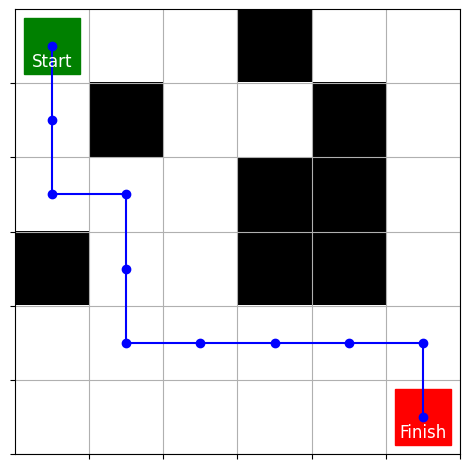

In [13]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

In [14]:
import gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [15]:
# Функция для генерации карты (из блокнота)
def generate_random_map(size, p, sd):
    valid = False
    np.random.seed(sd)
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False
    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]



In [16]:
# Инициализация среды
random_seed = 100
np.random.seed(random_seed)
random_map = generate_random_map(size=6, p=0.8, sd=random_seed)
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False)



In [17]:
# Функции
def choose_action(state, epsilon):
    action = 0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, env.action_space.n)
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action



In [18]:
def learn(state, state2, reward, action, done, gamma, lr_rate):
    if not done:
        max_future_q = np.max(Q[state2, :])
    else:
        max_future_q = 0
    current_q = Q[state, action]
    target_q = reward + gamma * max_future_q
    Q[state, action] = current_q + lr_rate * (target_q - current_q)



In [19]:
# Функция для запуска обучения с заданными гиперпараметрами
def run_experiment(gamma, lr_rate, epsilon):
    np.random.seed(random_seed)
    total_games = 10000
    max_steps = 100
    global Q  # Q-таблица глобальная, чтобы не пересоздавать
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    wins = 0
    consecutive_wins = 0
    first_five_wins_game = None

    for game in tqdm(range(total_games)):
        state = env.reset()
        t = 0
        while t < max_steps:
            t += 1
            action = choose_action(state, epsilon)
            state2, reward, done, info = env.step(action)
            if t == max_steps:
                done = True
            learn(state, state2, reward, action, done, gamma, lr_rate)
            state = state2
            if done:
                if reward == 1:
                    wins += 1
                    consecutive_wins += 1
                    if consecutive_wins >= 5 and first_five_wins_game is None:
                        first_five_wins_game = game + 1
                else:
                    consecutive_wins = 0
                break
    return wins, first_five_wins_game



100%|██████████| 10000/10000 [00:05<00:00, 1879.72it/s]


gamma=0.1: 7914 побед


100%|██████████| 10000/10000 [00:05<00:00, 1962.32it/s]


gamma=0.5: 7914 побед


100%|██████████| 10000/10000 [00:05<00:00, 1806.28it/s]


gamma=0.8: 7914 побед


100%|██████████| 10000/10000 [00:05<00:00, 1844.37it/s]


gamma=0.9: 7936 побед


100%|██████████| 10000/10000 [00:05<00:00, 1795.25it/s]


gamma=0.99: 7944 побед


100%|██████████| 10000/10000 [00:05<00:00, 1851.04it/s]


lr_rate=0.1: 7930 побед


100%|██████████| 10000/10000 [00:05<00:00, 1954.61it/s]


lr_rate=0.3: 7965 побед


100%|██████████| 10000/10000 [00:05<00:00, 1819.97it/s]


lr_rate=0.5: 7978 побед


100%|██████████| 10000/10000 [00:05<00:00, 1851.52it/s]


lr_rate=0.7: 7886 побед


100%|██████████| 10000/10000 [00:05<00:00, 1949.97it/s]


lr_rate=0.9: 7914 побед


100%|██████████| 10000/10000 [00:05<00:00, 1910.22it/s]


epsilon=0.01: 9107 побед


100%|██████████| 10000/10000 [00:05<00:00, 1798.18it/s]


epsilon=0.05: 8634 побед


100%|██████████| 10000/10000 [00:04<00:00, 2040.45it/s]


epsilon=0.1: 7914 побед


100%|██████████| 10000/10000 [00:05<00:00, 1894.70it/s]


epsilon=0.2: 6536 побед


100%|██████████| 10000/10000 [00:04<00:00, 2126.61it/s]


epsilon=0.3: 5055 побед


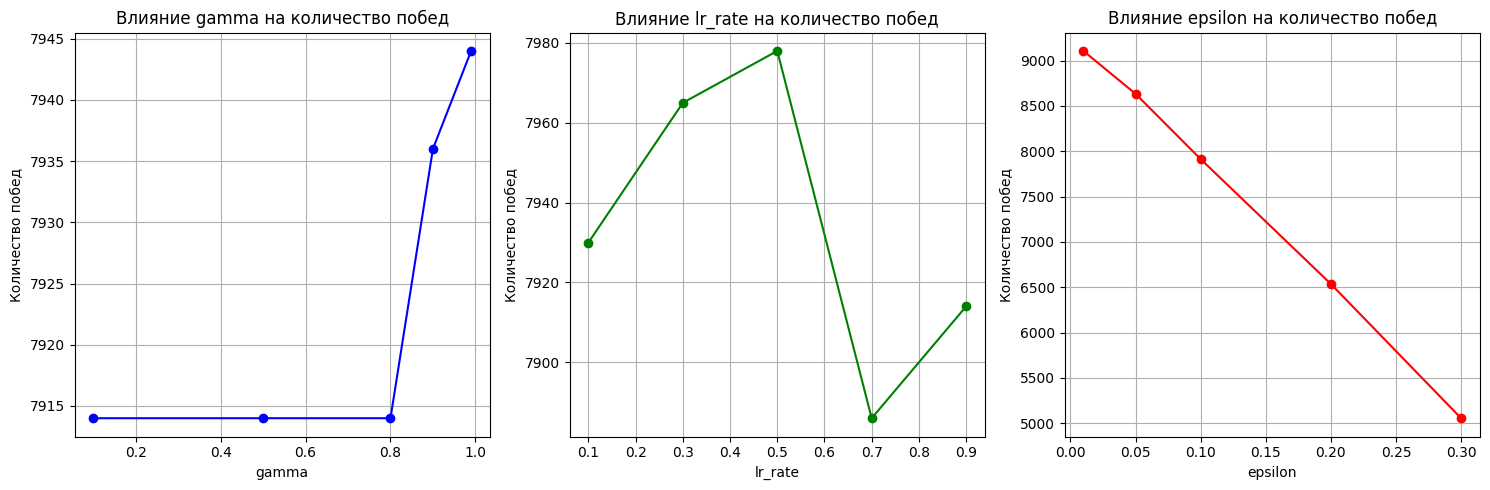

In [20]:
# Эксперименты
gamma_values = [0.1, 0.5, 0.8, 0.9, 0.99]
lr_rate_values = [0.1, 0.3, 0.5, 0.7, 0.9]
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3]

# Списки для хранения результатов
gamma_wins = []
lr_rate_wins = []
epsilon_wins = []

# Эксперимент 1: варьируем gamma
for gamma in gamma_values:
    wins, _ = run_experiment(gamma=gamma, lr_rate=0.9, epsilon=0.1)
    gamma_wins.append(wins)
    print(f"gamma={gamma}: {wins} побед")

# Эксперимент 2: варьируем lr_rate
for lr_rate in lr_rate_values:
    wins, _ = run_experiment(gamma=0.8, lr_rate=lr_rate, epsilon=0.1)
    lr_rate_wins.append(wins)
    print(f"lr_rate={lr_rate}: {wins} побед")

# Эксперимент 3: варьируем epsilon
for epsilon in epsilon_values:
    wins, _ = run_experiment(gamma=0.8, lr_rate=0.9, epsilon=epsilon)
    epsilon_wins.append(wins)
    print(f"epsilon={epsilon}: {wins} побед")

# Построение графиков
plt.figure(figsize=(15, 5))

# График для gamma
plt.subplot(1, 3, 1)
plt.plot(gamma_values, gamma_wins, marker='o', color='blue')
plt.title('Влияние gamma на количество побед')
plt.xlabel('gamma')
plt.ylabel('Количество побед')
plt.grid(True)

# График для lr_rate
plt.subplot(1, 3, 2)
plt.plot(lr_rate_values, lr_rate_wins, marker='o', color='green')
plt.title('Влияние lr_rate на количество побед')
plt.xlabel('lr_rate')
plt.ylabel('Количество побед')
plt.grid(True)

# График для epsilon
plt.subplot(1, 3, 3)
plt.plot(epsilon_values, epsilon_wins, marker='o', color='red')
plt.title('Влияние epsilon на количество побед')
plt.xlabel('epsilon')
plt.ylabel('Количество побед')
plt.grid(True)

plt.tight_layout()
plt.show()

#Softmax

In [ ]:
def choose_action_softmax(state, tau=0.1):
    q_values = Q[state, :]
    exp_q = np.exp(q_values / tau)  # Экспонента Q-значений
    probabilities = exp_q / np.sum(exp_q)  # Нормализация в вероятности
    return np.random.choice(np.arange(env.action_space.n), p=probabilities)

#UCB

In [ ]:
def choose_action_ucb(state, c=1.0, t=1):
    N_state_action = np.maximum(N_state_action[state, :], 1e-10)  # Избегаем деления на 0
    ucb_values = Q[state, :] + c * np.sqrt(np.log(t + 1) / N_state_action)
    return np.argmax(ucb_values)

#Оптимистичные начальные оценки

100%|██████████| 10000/10000 [00:05<00:00, 1685.14it/s]


Стратегия epsilon: 7914 побед, пять побед подряд в игре 885


100%|██████████| 10000/10000 [00:06<00:00, 1504.67it/s]


Стратегия softmax: 4218 побед, пять побед подряд в игре 2338


100%|██████████| 10000/10000 [00:02<00:00, 3495.59it/s]


Стратегия ucb: 6553 побед, пять побед подряд в игре 1407


100%|██████████| 10000/10000 [00:06<00:00, 1651.77it/s]


Стратегия optimistic: 8512 побед, пять побед подряд в игре 35


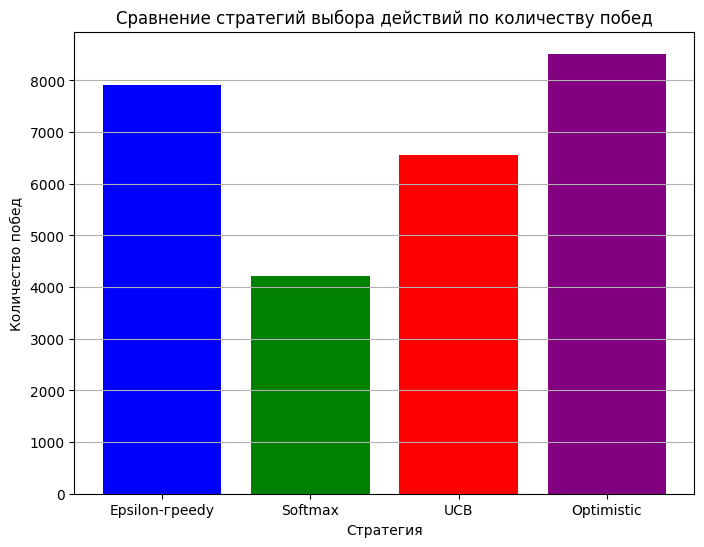

In [22]:
import gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Функция для генерации карты
def generate_random_map(size, p, sd):
    valid = False
    np.random.seed(sd)
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False
    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

# Инициализация среды
random_seed = 100
np.random.seed(random_seed)
random_map = generate_random_map(size=6, p=0.8, sd=random_seed)
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False)

# Гиперпараметры
gamma = 0.8
lr_rate = 0.9
epsilon = 0.1
total_games = 10000
max_steps = 100

# Глобальные переменные
Q = None
N_state_action = None
N_state = None

# Функции выбора действий
def choose_action_epsilon(state):
    action = 0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, env.action_space.n)
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def choose_action_softmax(state, tau=0.1):
    q_values = Q[state, :]
    exp_q = np.exp(q_values / tau)
    probabilities = exp_q / np.sum(exp_q)
    return np.random.choice(np.arange(env.action_space.n), p=probabilities)

def choose_action_ucb(state, c=1.0, t=1):
    N_state_action_safe = np.maximum(N_state_action[state, :], 1e-10)  # Избегаем деления на 0
    ucb_values = Q[state, :] + c * np.sqrt(np.log(t + 1) / N_state_action_safe)
    return np.argmax(ucb_values)

# Функция обучения
def learn(state, state2, reward, action, done):
    if not done:
        max_future_q = np.max(Q[state2, :])
    else:
        max_future_q = 0
    current_q = Q[state, action]
    target_q = reward + gamma * max_future_q
    Q[state, action] = current_q + lr_rate * (target_q - current_q)

# Функция для запуска эксперимента
def run_experiment(strategy, optimistic_init=False):
    global Q, N_state_action, N_state
    np.random.seed(random_seed)
    Q = np.ones((env.observation_space.n, env.action_space.n)) * 1.0 if optimistic_init else np.zeros((env.observation_space.n, env.action_space.n))
    N_state_action = np.zeros((env.observation_space.n, env.action_space.n))  # Для UCB
    N_state = np.zeros(env.observation_space.n)  # Для UCB
    wins = 0
    consecutive_wins = 0
    first_five_wins_game = None
    total_steps = 0  # Для UCB

    for game in tqdm(range(total_games)):
        state = env.reset()
        t = 0
        while t < max_steps:
            t += 1
            total_steps += 1
            if strategy == 'epsilon':
                action = choose_action_epsilon(state)
            elif strategy == 'softmax':
                action = choose_action_softmax(state, tau=0.1)
            elif strategy == 'ucb':
                action = choose_action_ucb(state, c=1.0, t=total_steps)
            else:  # optimistic
                action = choose_action_epsilon(state)  # Используем эпсилон-жадную для оптимистичных оценок
            N_state[state] += 1
            N_state_action[state, action] += 1
            state2, reward, done, info = env.step(action)
            if t == max_steps:
                done = True
            learn(state, state2, reward, action, done)
            state = state2
            if done:
                if reward == 1:
                    wins += 1
                    consecutive_wins += 1
                    if consecutive_wins >= 5 and first_five_wins_game is None:
                        first_five_wins_game = game + 1
                else:
                    consecutive_wins = 0
                break
    return wins, first_five_wins_game

# Эксперименты
strategies = ['epsilon', 'softmax', 'ucb', 'optimistic']
results = {}
for strategy in strategies:
    optimistic_init = (strategy == 'optimistic')
    wins, first_five = run_experiment(strategy, optimistic_init)
    results[strategy] = {'wins': wins, 'first_five': first_five}
    print(f"Стратегия {strategy}: {wins} побед, пять побед подряд в игре {first_five}")

# Построение графика
plt.figure(figsize=(8, 6))
strategies_names = ['Epsilon-греedy', 'Softmax', 'UCB', 'Optimistic']
wins = [results[strat]['wins'] for strat in strategies]
plt.bar(strategies_names, wins, color=['blue', 'green', 'red', 'purple'])
plt.title('Сравнение стратегий выбора действий по количеству побед')
plt.xlabel('Стратегия')
plt.ylabel('Количество побед')
plt.grid(True, axis='y')
plt.show()